##  Reinforcement Learning Individual Assignment - Antoine BOSSAN

In [ ]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-u6sbes4a
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-u6sbes4a
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done


In [ ]:
import os, sys
import gymnasium as gym
import time
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import text_flappy_bird_gym

In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

In [ ]:
NUM_EPISODES_PARAMETER_SWEEPING = 4000
NUM_EPISODES_FINAL_PARAMETERS = 10000

## I: Initializing Agent Classes

In [ ]:
class MC_Q_Agent:
    def __init__(self, eps, discount):
        '''This class implements the Monte Carlo Control algorithm for finding optimal policies,
         as described in Chapter 5.3 of the book "Reinforcement Learning: An Introduction" by Richard S. Sutton and Andrew G. Barto.
        The algorithm utilizes an Epsilon Greedy Policy to balance exploration and exploitation.
        '''
        self.v = defaultdict(float)
        self.eps = eps
        self.discount = discount
        self.q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.returns = defaultdict(lambda: [])

    def act(self, state):
        if np.random.uniform(0, 1) < self.eps:
            return env.action_space.sample()
        else:
            return np.argmax(self.q[state])

    def update(self, episode):
        G = 0
        for state in self.q:
            self.v[state] = np.max(self.q[state])
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.discount * G + reward
            self.returns[(state, action)].append(G)
            self.q[state][action] = np.mean(self.returns[(state, action)])

    def reset(self):
        self.q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.returns = defaultdict(lambda: [])

In [ ]:
class Lambda_SARSA_Agent:
    def __init__(self, eps, step_size, discount, s_lambda ):
        '''This class implements the Sarsa Lambda algorithm,
        as described in Chapter 12.7 of the book "Reinforcement Learning: An Introduction" by Richard S. Sutton and Andrew G. Barto.
        The algorithm utilizes an Epsilon Greedy Policy to balance exploration and exploitation.
        '''
        self.eps = eps
        self.step_size = step_size
        self.discount = discount
        self.s_lambda = s_lambda
        self.q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.eligibility_traces = defaultdict(lambda: np.zeros(env.action_space.n))
        self.v = defaultdict(float)


    def act(self, state):
        if np.random.uniform(0, 1) < self.eps:
            return env.action_space.sample()
        else:
            return np.argmax(self.q[state])

    def update(self, state, action, reward, next_state, next_action, done):
        delta = reward + self.discount * self.q[next_state][next_action] - self.q[state][action]
        self.eligibility_traces[state][action] += 1
        self.v[state] = np.max(self.q[state])

        for s in self.eligibility_traces:
            for a in range(env.action_space.n):
                self.q[s][a] += self.step_size * delta * self.eligibility_traces[s][a]
                self.eligibility_traces[s][a] *= self.discount * self.s_lambda

        if done:
            self.eligibility_traces = defaultdict(lambda: np.zeros(env.action_space.n))


    def reset(self):
        self.q = defaultdict(lambda: np.zeros(env.action_space.n))
        self.eligibility_traces = defaultdict(lambda: np.zeros(env.action_space.n))

## II: Parameter-Sweep Graphs

### II.a MCQ Parameter-Sweep Graph

In [ ]:
def run_mc_q_agent_training(mc_q_agent_params, num_episodes=NUM_EPISODES_PARAMETER_SWEEPING):
    mc_q_agent = MC_Q_Agent(**mc_q_agent_params)
    mc_q_agent_rewards = []
    mc_q_agent_scores = []

    for i in tqdm(range(num_episodes)):
        state = env.reset()
        state = state[0]
        done = False
        total_reward = 0
        episode = []

        while not done:
            action = mc_q_agent.act(state)
            next_state, reward, done, _, info = env.step(action)
            episode.append((state, action, reward))

            if done:
                reward = -1
            state = next_state
            total_reward += reward

        mc_q_agent.update(episode)
        mc_q_agent_scores.append(info['score'])
        mc_q_agent_rewards.append(total_reward)

    env.close()
    mc_q_agent.reset()

    return mc_q_agent_rewards, mc_q_agent_scores

In [ ]:
eps_values = np.linspace(0.095, 0.115, 2)
discount_values = np.linspace(0.88, 0.92, 2)
results = []

In [ ]:
for eps in eps_values:
    for discount in discount_values:
        mc_q_agent_params = {"eps": eps, "discount": discount}
        rewards, scores = run_mc_q_agent_training(mc_q_agent_params)
        results.append((eps, discount, rewards, scores))

100%|██████████| 4000/4000 [01:09<00:00, 57.70it/s]


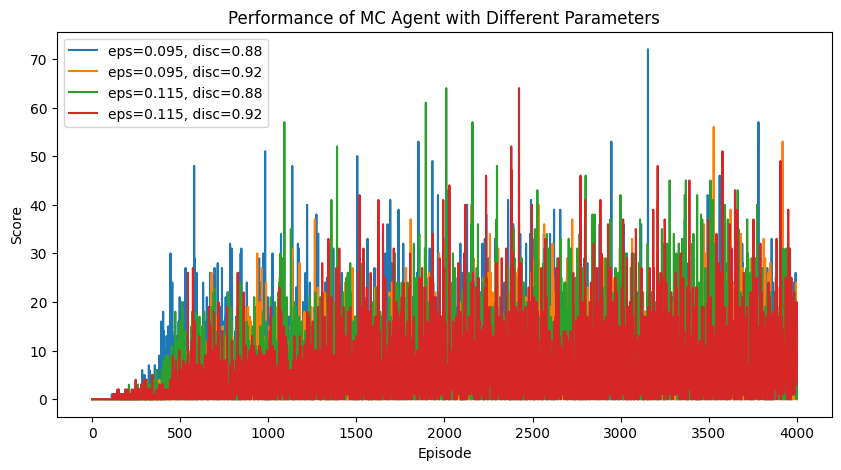

In [ ]:
def plot_results_mcq(results):
    plt.figure(figsize=(10, 5))

    for eps, discount, rewards, scores in results:
        plt.plot(scores, label=f'eps={eps}, disc={discount}')

    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Performance of MC Agent with Different Parameters')
    plt.legend()
    plt.show()

plot_results_mcq(results)

Saving best parameters

In [ ]:
def find_best_parameters_monte_carlo(results):
    max_cumulative_score = -float('inf')
    best_params = None

    for eps, discount, rewards, scores in results:
        cumulative_score = sum(scores)

        if cumulative_score > max_cumulative_score:
            max_cumulative_score = cumulative_score
            best_params = (eps, discount)
    return best_params, max_cumulative_score

best_params_score_mcq = find_best_parameters_monte_carlo(results)

In [ ]:
(best_eps_mcq, best_discount_mcq), score_mcq = best_params_score_mcq

In [ ]:
best_eps_mcq, best_discount_mcq

(0.115, 0.88)

### II.b Lambda Sarsa Parameter-Sweep Graph

In [ ]:
def run_sarsa_agent_training(sarsa_agent_params, num_episodes=NUM_EPISODES_PARAMETER_SWEEPING):
    lambda_sarsa_agent = Lambda_SARSA_Agent(**sarsa_agent_params)
    lambda_sarsa_agent_rewards = []
    lambda_sarsa_agent_scores = []

    for i in tqdm(range(num_episodes)):
        state = env.reset()
        state = state[0]
        done = False
        total_reward = 0
        episode = []
        action = lambda_sarsa_agent.act(state)
        while not done:
            next_state, reward, done, _, info = env.step(action)
            next_action = lambda_sarsa_agent.act(next_state)
            episode.append((state, action, reward, next_state, next_action))
            if done:
                reward = -1
                lambda_sarsa_agent_scores.append(info['score'])
            lambda_sarsa_agent.update(state, action, reward, next_state, next_action, done)
            state = next_state
            action = next_action
            total_reward += reward
        lambda_sarsa_agent_rewards.append(total_reward)

    env.close()
    lambda_sarsa_agent.reset()
    return lambda_sarsa_agent_rewards, lambda_sarsa_agent_scores

In [ ]:
eps_values = np.linspace(0.15, 0.25, 2)
discount_values = np.linspace(0.85, 0.95, 2)
lambda_values = np.linspace(0.0, 1, 3)
step_size_values = np.linspace(0.15, 0.25, 2)
results = []

In [ ]:
for eps in eps_values:
    for discount in discount_values:
        for lambda_val in lambda_values:
          for step_size in step_size_values:
              params = {"eps": eps, "discount": discount,"step_size":step_size,  "s_lambda": lambda_val}
              rewards, scores = run_sarsa_agent_training(params)
              results.append((eps, step_size, discount, lambda_val, rewards, scores))

100%|██████████| 4000/4000 [00:15<00:00, 258.36it/s]


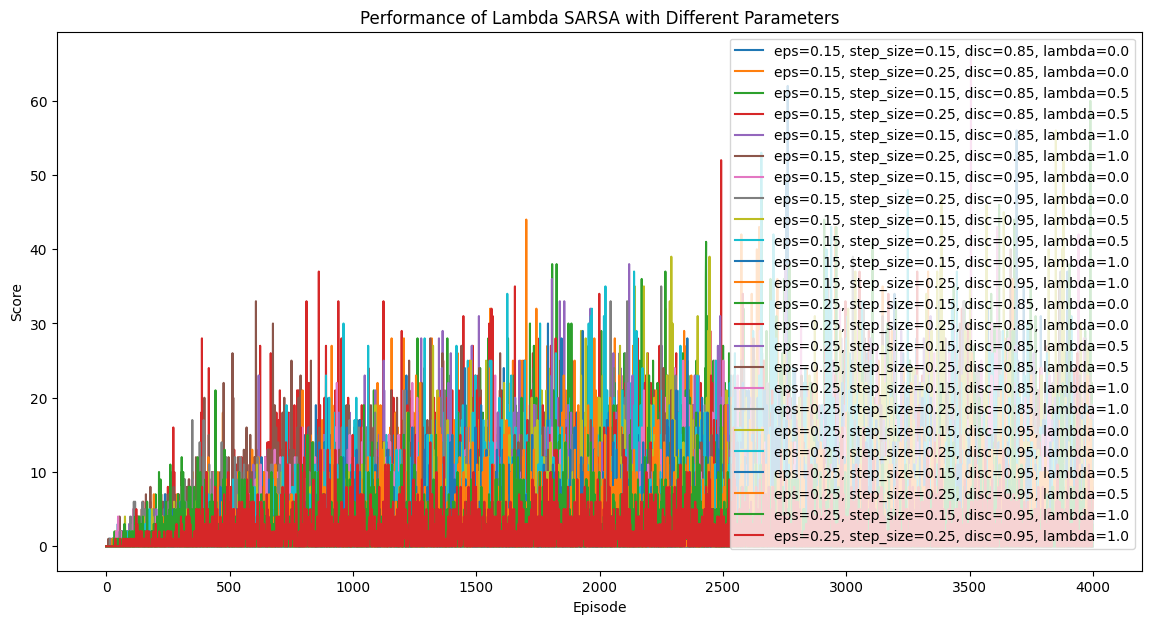

In [ ]:
def plot_results_lambda_sarsa(results):
    plt.figure(figsize=(14, 7))
    for eps, step_size, discount, lambda_val, rewards, scores in results:
        plt.plot(scores, label=f'eps={eps}, step_size={step_size}, disc={discount}, lambda={lambda_val}')

    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Performance of Lambda SARSA with Different Parameters')
    plt.legend()
    plt.show()

plot_results_lambda_sarsa(results)

Saving best parameters

In [ ]:
def find_best_parameters_lambda_sarsa(results):
    max_cumulative_score = -float('inf')
    best_params = None

    for eps, step_size, discount, lambda_val, rewards, scores in results:
        cumulative_score = sum(scores)
        if cumulative_score > max_cumulative_score:
            max_cumulative_score = cumulative_score
            best_params = (eps, step_size, discount, lambda_val)

    return best_params, max_cumulative_score

best_param_and_scores = find_best_parameters_lambda_sarsa(results)

In [ ]:
(best_eps_sarsa, best_step_size_sarsa, best_discount_sarsa, best_lambda_sarsa), score_sarsa = best_param_and_scores

In [ ]:
best_eps_sarsa, best_step_size_sarsa, best_discount_sarsa, best_lambda_sarsa

(0.15, 0.25, 0.85, 0.5)

##III: State-Value Function Plots

In [ ]:
#Agent instantiation

In [ ]:
mc_q_agent = MC_Q_Agent(eps=best_eps_mcq, discount=best_discount_mcq)

In [ ]:
lambda_sarsa_agent = Lambda_SARSA_Agent(eps=best_eps_sarsa, step_size=best_step_size_sarsa, discount=best_discount_sarsa, s_lambda=best_lambda_sarsa)

In [ ]:
# Initializing reward tracking list
mc_q_agent_rewards = []
lambda_sarsa_agent_rewards = []

In [ ]:
# Initializing score tracking lists
mc_q_agent_scores = []
lambda_sarsa_agent_scores = []

### Training Monte Carlo Agent

In [ ]:
for i in tqdm(range(NUM_EPISODES_FINAL_PARAMETERS)):
    state = env.reset()
    state = state[0]
    done = False
    total_reward = 0
    episode = []

    while not done:
        action = mc_q_agent.act(state)
        next_state, reward, done, _, info = env.step(action)
        episode.append((state, action, reward))

        if done:
            reward = -1
        state = next_state
        total_reward += reward

    mc_q_agent.update(episode)

    mc_q_agent_scores.append(info['score'])
    mc_q_agent_rewards.append(total_reward)

env.close()
mc_q_agent.reset()

100%|██████████| 10000/10000 [16:04<00:00, 10.37it/s]


### Training Loop Lambda Sarsa

In [ ]:
for i in tqdm(range(NUM_EPISODES_FINAL_PARAMETERS)):
    state = env.reset()
    state = state[0]
    done = False
    total_reward = 0
    episode = []
    action = lambda_sarsa_agent.act(state)

    while not done:
        next_state, reward, done, _, info = env.step(action)
        next_action = lambda_sarsa_agent.act(next_state)
        episode.append((state, action, reward, next_state, next_action))

        if done:
            reward = -1
            lambda_sarsa_agent_scores.append(info['score'])

        lambda_sarsa_agent.update(state, action, reward, next_state, next_action, done)
        state = next_state
        action = next_action
        total_reward += reward
    lambda_sarsa_agent_rewards.append(total_reward)

env.close()
lambda_sarsa_agent.reset()

100%|██████████| 10000/10000 [02:02<00:00, 81.77it/s]


### III.a MCQ State-Value Function Plots

In [ ]:
x_coords = [coord[0] for coord in mc_q_agent.v.keys()]
y_coords = [coord[1] for coord in mc_q_agent.v.keys()]

grid_width = max(x_coords) - min(x_coords) + 1
grid_height = max(y_coords) - min(y_coords) + 1

density_grid = np.full((grid_height, grid_width), np.nan)

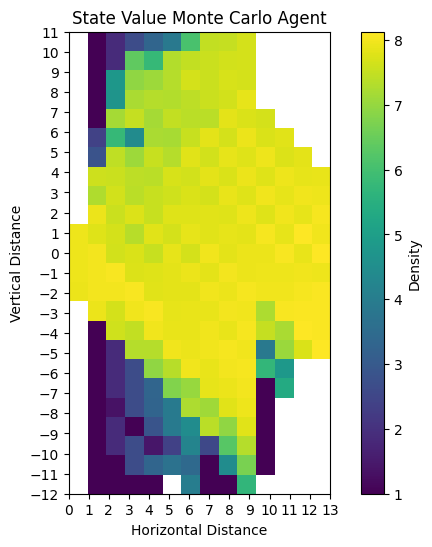

In [ ]:
for (x, y), density in mc_q_agent.v.items():
    grid_x = x - min(x_coords)
    grid_y = y - min(y_coords)
    density_grid[grid_y, grid_x] = density

plt.figure(figsize=(8, 6))
im = plt.imshow(density_grid, interpolation='nearest', cmap='viridis', extent=[min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.colorbar(im, label='Density')
plt.title('State Value Monte Carlo Agent')
plt.xlabel('Horizontal Distance')
plt.ylabel('Vertical Distance')

plt.xticks(np.arange(min(x_coords), max(x_coords)+1, 1))
plt.yticks(np.arange(min(y_coords), max(y_coords)+1, 1))

plt.show()

### III.b Lamdba Sarsa State-Value Function Plots

In [ ]:
x_coords = [coord[0] for coord in lambda_sarsa_agent.v.keys()]
y_coords = [coord[1] for coord in lambda_sarsa_agent.v.keys()]

grid_width = max(x_coords) - min(x_coords) + 1
grid_height = max(y_coords) - min(y_coords) + 1

density_grid = np.full((grid_height, grid_width), np.nan)

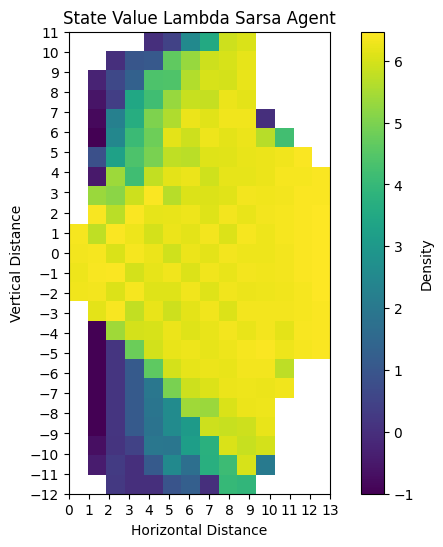

In [ ]:
for (x, y), density in lambda_sarsa_agent.v.items():
    grid_x = x - min(x_coords)
    grid_y = y - min(y_coords)
    density_grid[grid_y, grid_x] = density

plt.figure(figsize=(8, 6))
im = plt.imshow(density_grid, interpolation='nearest', cmap='viridis', extent=[min(x_coords), max(x_coords), min(y_coords), max(y_coords)])

plt.colorbar(im, label='Density')
plt.title('State Value Lambda Sarsa Agent')
plt.xlabel('Horizontal Distance')
plt.ylabel('Vertical Distance')

plt.xticks(np.arange(min(x_coords), max(x_coords)+1, 1))
plt.yticks(np.arange(min(y_coords), max(y_coords)+1, 1))

plt.show()

## IV: Comparaison of Performance

### IV.I : Comparaison of the rewards

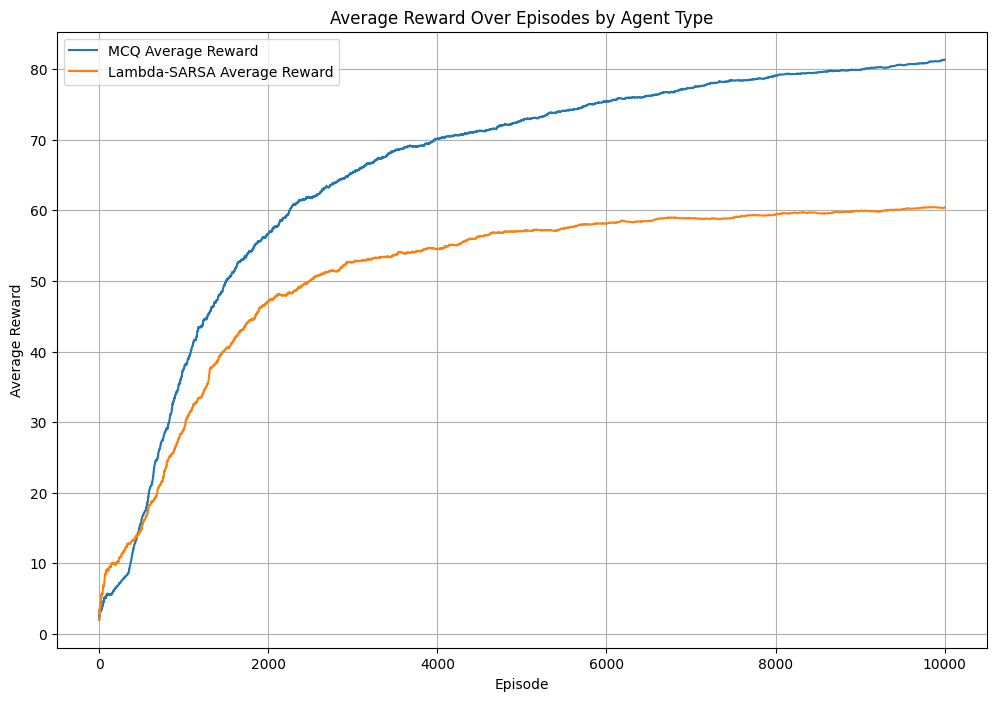

In [ ]:
cumulative_averages_mcq = np.cumsum(mc_q_agent_rewards) / np.arange(1, len(mc_q_agent_rewards) + 1)
cumulative_averages_lambda_sarsa = np.cumsum(lambda_sarsa_agent_rewards) / np.arange(1, len(lambda_sarsa_agent_rewards) + 1)

plt.figure(figsize=(12, 8))
plt.plot(cumulative_averages_mcq, label="MCQ Average Reward")
plt.plot(cumulative_averages_lambda_sarsa, label="Lambda-SARSA Average Reward")

plt.title('Average Reward Over Episodes by Agent Type')
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()

### IV.b Comparaison of the scores

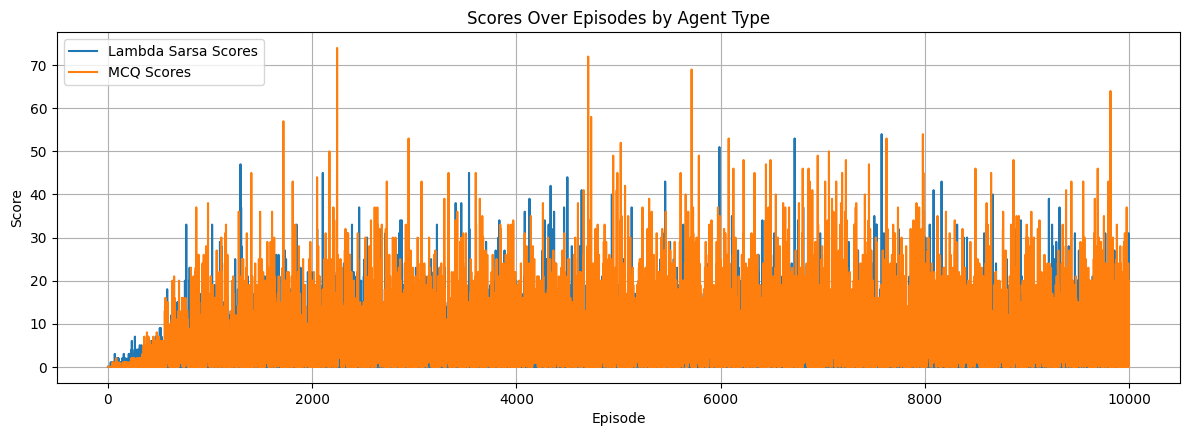

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 3)
plt.plot(lambda_sarsa_agent_scores, label="Lambda Sarsa Scores")
plt.plot(mc_q_agent_scores, label="MCQ Scores")
plt.title('Scores Over Episodes by Agent Type')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()


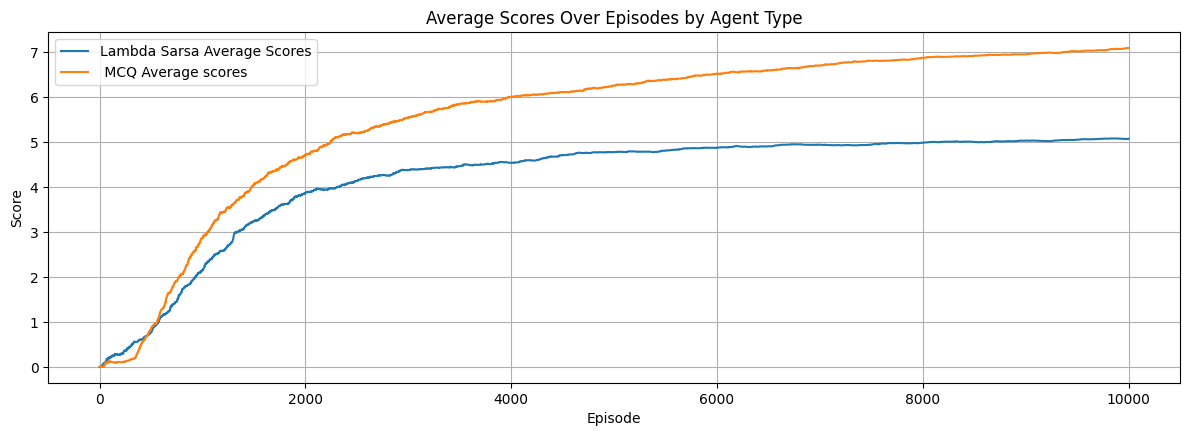

In [ ]:
plt.figure(figsize=(12, 12))

cumulative_lambda_sarsa_scores = np.cumsum(lambda_sarsa_agent_scores) / np.arange(1, len(lambda_sarsa_agent_scores) + 1)
cumulative_policy_scores = np.cumsum(mc_q_agent_scores) / np.arange(1, len(mc_q_agent_scores) + 1)

plt.subplot(3, 1, 3)
plt.plot(cumulative_lambda_sarsa_scores, label="Lambda Sarsa Average Scores")
plt.plot(cumulative_policy_scores, label=" MCQ Average scores")
plt.title('Average Scores Over Episodes by Agent Type')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.legend(loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()